## Summary
We hypothesized that the difference in ALS progression results from the interaction of multiple pathways and these interactions are captured in the gene expression profile of the individuals. By comparing gene expression in a patient population, we can identify subgroups of patients and it allows us to assess if they were progressing fast or slow according to their clinical data.
To identify the mechanisms involved in disease progression, we performed a differential expression analysis followed by pathway overrepresentation analysis.
 
We had access to gene expression data from motor neurons that were derived from induced pluripotent stem cells generated from 134 ALS patients.  To eliminate technical noise and capture only the biology in the data, we normalized it and corrected it for the differentiation stages of the iPScells. Next, we performed unsupervised hierarchical clustering and we identified two main gene expression clusters.
 
We performed different statistical tests to assess the clinical relevance of the clusters and found significant differences in the ALS functional rating scale (ALSFRS) progression slope and the marker SB100, which are associated with disease progression. We did not observe any significance difference in age of symptom onset, sex, race, Escorial criteria, anatomical site of onset, ALS functional rating scale (ALSFRS) at baseline or latest measurements, cognitive behavior screen (CBS) scores (at baseline, latest measurement or progression slope)or in the rest of cell differentiation markers. The limited data provided did not allow us to test more clinical or environmental parameters 
 
After observing the correlation of the clusters with variables related to disease progression, we assessed the difference in gene expression between the clusters. We identified 11366 genes that were differentially expressed after correcting for multiple testing (FDR<0.05). We then performed an overrepresentation pathways analysis at Reactome to identify the mechanisms in which these genes were involved stratifying by down- and up-regulated genes. The down-regulated genes are overrepresented significantly in multiple pathways (FILE). 


# Data analysis
We started the analysis by exploring the data and removing the technical artefacts when possible. It is known that transcriptomic data is prone to batch effects and the fact that the iPScells could be in different differentiation stages, made data exploration and normalization our priority.
 
We first explored the normalized Deseq2 dataset by removing possible batch effects with a Multidimensional scaling (MDS) analysis. We then decided to look directly at the gene counts. To achieve this, we first extracted all the gene counts per patient from the different folders and created a matrix with gene counts and eliminated the control group.



In [1]:
# Load librarys
library('edgeR')
library('limma')
library('Glimma')
library('ggplot2')
library('RColorBrewer')
library('morpheus')
library('org.Hs.eg.db')
library("dplyr")
library("gplots")

Loading required package: limma

Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:limma’:

    plotMA


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table,

In [9]:
# Reading principal path L3 counts data to extrac txt files
l3_count_main_path <- "/home/jupyter/end-als/transcriptomics-data/L3_counts"
# List of folder in L3_counts
l3_count_main_path_list <- list.files(path = l3_count_main_path)
# Declare variable just for concatenate txt files
all_transcriptomic_counts <- "Principal"
flag <- TRUE
for (folder in l3_count_main_path_list){
    # Get sub-folder path
    subfolder <- list.files(path=paste(l3_count_main_path, folder, sep='/'))
    # If the folder contains more than one file the is excluded
    if (length(subfolder) > 1){
        next
    }
    # Read last file this path contain the name of .txt file
    exon_txt_file <- list.files(path=paste(l3_count_main_path, folder, subfolder, sep='/'))
    # Concatenate all path to read csv
    complete_l3_count_path <- paste(l3_count_main_path, folder, subfolder, exon_txt_file, sep='/')
    
    # Reading exo.txt file
    l3_counts_per_id <- read.table(complete_l3_count_path, sep = "\t", header=TRUE)
    # Select genes columns and counts
    l3_counts_per_id <- subset(l3_counts_per_id, select=(c(1,7)))
    # Change the name of columns for genes for genes and counts per id
    colnames(l3_counts_per_id) <- c("genes", folder)
    # If is the first iterarion then enter into if and save file in all_transcript_count to by concacatenate later
    if(flag){
        flag<- FALSE
        all_transcriptomic_counts <- l3_counts_per_id
        next
    }
    # Join all count in single file
    all_transcriptomic_counts <- left_join(x = all_transcriptomic_counts, y = l3_counts_per_id, by = "genes", all.x = TRUE)
}
# Write csv file of raw counts
write.csv(all_transcriptomic_counts, "raw_L3counts_data.csv")

The next step was to perform the normalization on the raw count matrix in edgeR. For this we removed genes with low reads and then generated a new MDS, but we still saw the heterogeneity.

In [10]:
# To performance MDS with color by case and ctrl is necesario get the groups from clinical data portal data
clinical_data_portal <- read.csv('/home/jupyter/end-als/clinical-data/filtered-metadata/metadata/aals_dataportal_datatable.csv')
# Creating dataframe just with data that we need


clinical_data_portal_subset <- data.frame(clinical_data_portal$Participant_ID, clinical_data_portal$Sex,
                                         clinical_data_portal$Race, clinical_data_portal$Subject.Group, 
                                         clinical_data_portal$Site.of.Onset, clinical_data_portal$NEFH..SMI32.,
                                         clinical_data_portal$ISL1, clinical_data_portal$`NKX6.1`, 
                                         clinical_data_portal$TUBB3..TuJ1., clinical_data_portal$s100b,
                                         clinical_data_portal$ALSFRS.R.Baseline, clinical_data_portal$ALSFRS.R.Latest,
                                         clinical_data_portal$ALSFRS.R.Progression.Slope,
                                         clinical_data_portal$CBS.Baseline, clinical_data_portal$CBS.Latest,
                                         clinical_data_portal$CBS.Progression.Slope)
# Change col names
colnames(clinical_data_portal_subset) <- c("Participant_ID", "Sex", "Race", "SubjectGroup", "SiteOfOnset", "NEFH",
                                          "ISL1", "NKX6", "TUBB3", "s100b", "ALSFRSBaseline", "ALSFRSLatest", "ALSFRSProgressionSlope",
                                            "CBSBaseline", "CBSLatest", "CBS.Progression.Slope")
# Transpose data to join data portal and raw counts data
all_transcriptomic_counts_transpose <- t(all_transcriptomic_counts)
# Change the columns names for the ids
colnames(all_transcriptomic_counts_transpose) <- all_transcriptomic_counts_transpose[1, ]
# Delete  ids from the first row 
all_transcriptomic_counts_transpose <- data.frame(all_transcriptomic_counts_transpose[-c(1), ])
# set participant Id as columns
all_transcriptomic_counts_transpose$Participant_ID <- rownames(all_transcriptomic_counts_transpose)
# Join raw counts and data portal 
all_transcriptomic_counts_and_data_portal <- left_join(x = all_transcriptomic_counts_transpose, 
                                       y = clinical_data_portal_subset, by = "Participant_ID", all.x = TRUE)

# Save transcripts groups to use latter in Difererntial expression analysis
transcripts_groups <- all_transcriptomic_counts_and_data_portal[c("Participant_ID", "Sex", "Race", 
                                                                 "SubjectGroup", "SiteOfOnset", "NEFH",
                                                                 "ISL1", "NKX6", "TUBB3", "s100b", "ALSFRSBaseline",
                                                                 "ALSFRSLatest", "ALSFRSProgressionSlope", "CBSBaseline", 
                                                                 "CBSLatest", "CBS.Progression.Slope")]

transcripts_groups$SubjectGroup[which(transcripts_groups$SubjectGroup != "Healthy Control")]  <- "ALS"
# Delete columns from raw counts
all_transcriptomic_counts_and_data_portal <- subset(all_transcriptomic_counts_and_data_portal, select=-c( Sex, Race, 
                                                                 SubjectGroup, SiteOfOnset, NEFH,
                                                                 ISL1, NKX6, TUBB3, s100b, ALSFRSBaseline,
                                                                 ALSFRSLatest, ALSFRSProgressionSlope, CBSBaseline, 
                                                                 CBSLatest, CBS.Progression.Slope))


In [11]:
# report process to transpose data

# Transpose data to have id in columns
all_transcriptomic_counts_and_data_portal <- t(all_transcriptomic_counts_and_data_portal)
# Change the columns names for  ids patinets
colnames(all_transcriptomic_counts_and_data_portal) <- all_transcriptomic_counts_and_data_portal[60676, ]
# Delete  ids from the last row 
all_transcriptomic_counts_and_data_portal <- all_transcriptomic_counts_and_data_portal[-c(60676), ]
# Convert matrix to data frame
all_transcriptomic_counts_and_data_portal <- data.frame(all_transcriptomic_counts_and_data_portal)
# Set genes ids
genes_id <- rownames(all_transcriptomic_counts_and_data_portal)
# # changing the type data chart to numeric
all_transcriptomic_counts_and_data_portal <- as.data.frame(sapply(all_transcriptomic_counts_and_data_portal, as.numeric))
# Set row names genes to the new data colletion
rownames(all_transcriptomic_counts_and_data_portal) <- genes_id

In [12]:
# Filter just cases from raw data
all_transcriptomic_counts_and_data_portal <- all_transcriptomic_counts_and_data_portal [transcripts_groups$SubjectGroup == 'ALS']
transcripts_groups <- transcripts_groups[transcripts_groups$SubjectGroup == 'ALS', ]

# Filter by markers
# it'is neccesary create boolean list of each marker to filter all missings values
# NEFH marker filter
NEFH_boolean_list <- !is.na(transcripts_groups$NEFH)
all_transcriptomic_counts_and_data_portal <- all_transcriptomic_counts_and_data_portal [NEFH_boolean_list]
transcripts_groups <- transcripts_groups[NEFH_boolean_list, ]

# ISL1 marker filter
ISL1_boolean_list <- !is.na(transcripts_groups$ISL1)
all_transcriptomic_counts_and_data_portal <- all_transcriptomic_counts_and_data_portal [ISL1_boolean_list]
transcripts_groups <- transcripts_groups[ISL1_boolean_list, ]

# NKX6 marker filter
NKX6_boolean_list <- !is.na(transcripts_groups$NKX6)
all_transcriptomic_counts_and_data_portal <- all_transcriptomic_counts_and_data_portal [NKX6_boolean_list]
transcripts_groups <- transcripts_groups[NKX6_boolean_list, ]

# TUBB3 marker filter
TUBB3_boolean_list <- !is.na(transcripts_groups$TUBB3)
all_transcriptomic_counts_and_data_portal <- all_transcriptomic_counts_and_data_portal [TUBB3_boolean_list]
transcripts_groups <- transcripts_groups[TUBB3_boolean_list, ]

# s100b marker filter
s100b_boolean_list <- !is.na(transcripts_groups$s100b)
all_transcriptomic_counts_and_data_portal <- all_transcriptomic_counts_and_data_portal [s100b_boolean_list]
transcripts_groups <- transcripts_groups[s100b_boolean_list, ]

In [15]:
dgelist_edgeR_normalize <- DGEList(counts = as.matrix(all_transcriptomic_counts_and_data_portal), group = transcripts_groups$SubjectGroup)
# Filter data by cpm
keep_data<- filterByExpr(dgelist_edgeR_normalize)
dgelist_edgeR_normalize<- dgelist_edgeR_normalize[keep_data, , keep.lib.sizes=FALSE]
# Normalize Data
edgeR_normalize_data <- calcNormFactors(dgelist_edgeR_normalize)
#edgeR_normalize_data <- logcpm <- cpm(edgeR_normalize_data, log=TRUE)
dgelist_edgeR_normalize <- DGEList(counts = as.matrix(edgeR_normalize_data), group = transcripts_groups$SubjectGroup)

Warning message in filterByExpr.DGEList(dgelist_edgeR_normalize):
“All samples appear to belong to the same group.”


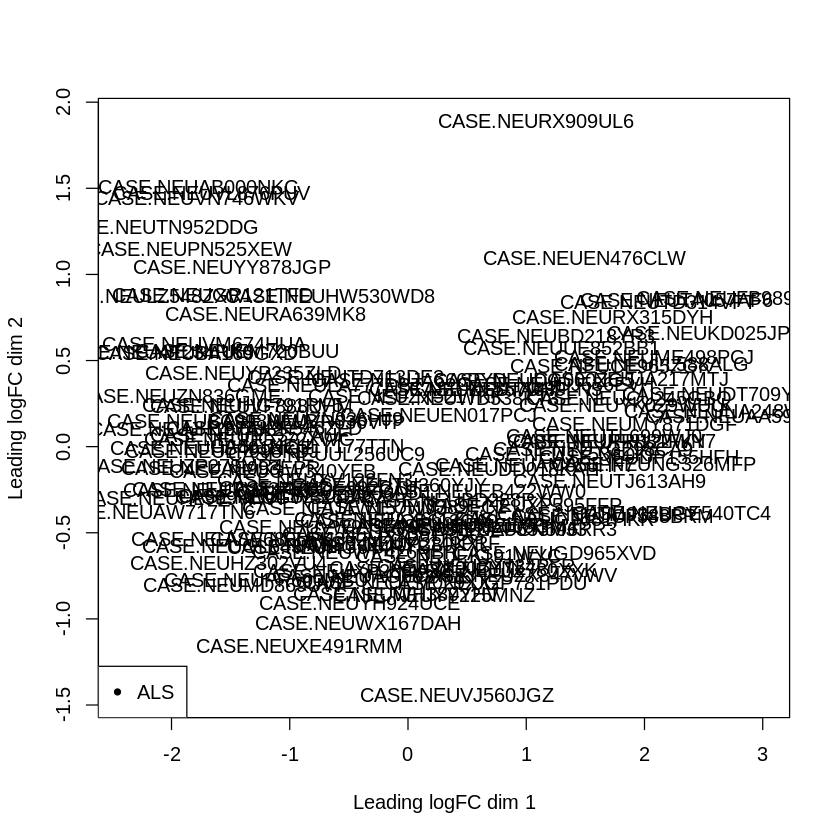

In [16]:
# plot MDS
plotMDS(dgelist_edgeR_normalize, col=as.numeric(dgelist_edgeR_normalize$samples$group))
legend("bottomleft", as.character(unique(dgelist_edgeR_normalize$samples$group)), col=1:3, pch=20)

As quartile normalization, followed by log transformation of the data has been suggested as a good approach to remove batch effects, we implemented it using limma. When we included all the genes, we saw a homogeneous model, but after removing the low count genes, we also see heterogeneity. We decided to use this data for further analysis including the staining markers for cell differentiation as covariates as suggested in one of the Kaggle discussions. We also included sex and race as covariates, as they affect gene expression. We also wanted to include age, as it affects the transcriptomic profile, but this was not possible, as there were many missing values in the data set.

In [17]:
# Calculate count per million and keep samples
cpm_quantile_transform <- cpm(all_transcriptomic_counts_and_data_portal)
# thresh_cpm to filter data
thresh_cpm <- cpm_quantile_transform > 0.5
keep_quantile_data <- rowSums(thresh_cpm) >= 2
counts.keep_quantile_data<- all_transcriptomic_counts_and_data_portal[keep_quantile_data,]
# Quantile normalization
quantile_normalization_data <-normalizeQuantiles(counts.keep_quantile_data, ties=TRUE)
# log transformation
log_quantile_norm_data <- log1p(quantile_normalization_data)
#created dglist to make MDS
dgelist_quantile_data <- DGEList(counts = as.matrix(log_quantile_norm_data), group = transcripts_groups$SubjectGroup)

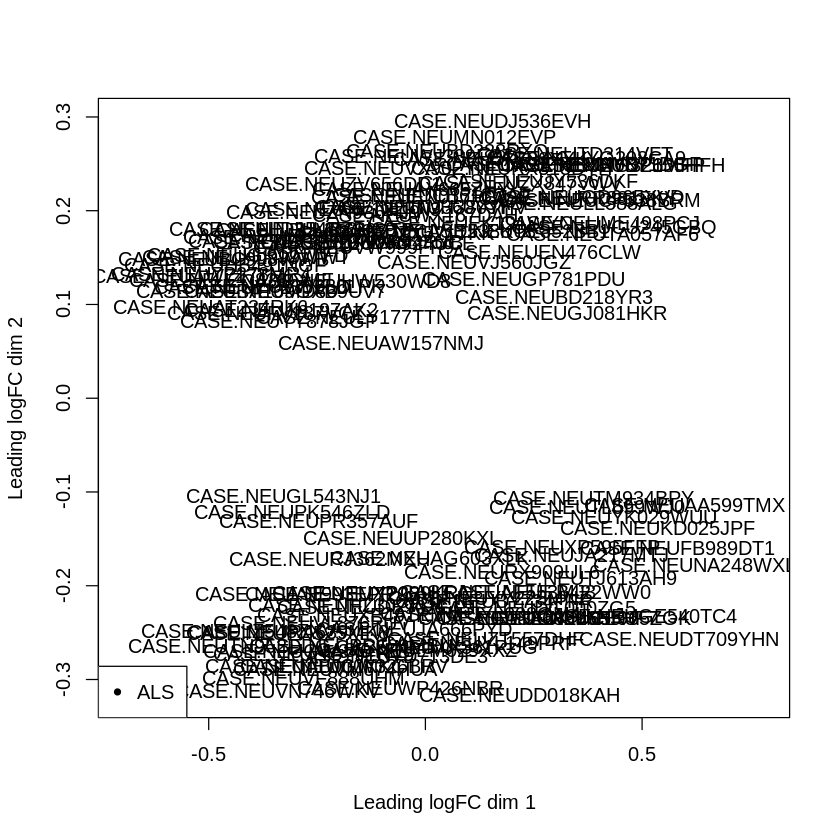

In [18]:
# plot MDS
plotMDS(dgelist_quantile_data, col=as.numeric(dgelist_quantile_data$samples$group))
legend("bottomleft", as.character(unique(dgelist_quantile_data$samples$group)), col=1:3, pch=20)

To identify subgroups of patients with different transcriptomic profiles we decided to follow an unsupervised clustering approach. However, for this approach we needed to remove the heterogeneity in the data caused by the different differentiation stages of the iPScells. We use the removeBatchEffect function in the limma package to correct for the staining markers. We included 5 out 6 markers as covariates, as nestin had 38 missing values. We removed 11 cases for this analysis because they had missing values for the markers. After generating
a MDS plot, we did not observe any more heterogeneity in the data.


In [19]:
# remove bath effect by markers
quantile_data_removeBatchEffect <- removeBatchEffect(log_quantile_norm_data, covariates=transcripts_groups[c("NEFH", "ISL1", "NKX6", "TUBB3", "s100b")])

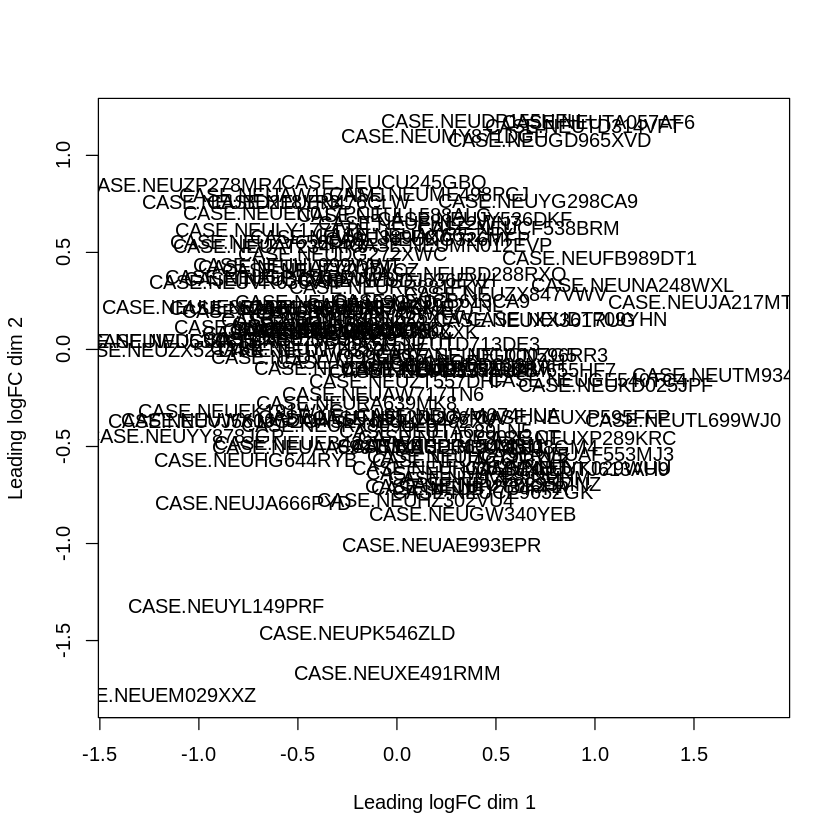

In [20]:
# Plot MDS After generating an MDS plot, we did not observe any more heterogeneity in the data.
plotMDS(quantile_data_removeBatchEffect)

We did not use this correction for the differential expression analysis as this function is not intended to be used prior to linear modelling. Thus, for the differential expression analysis we continued using the markers as covariates.

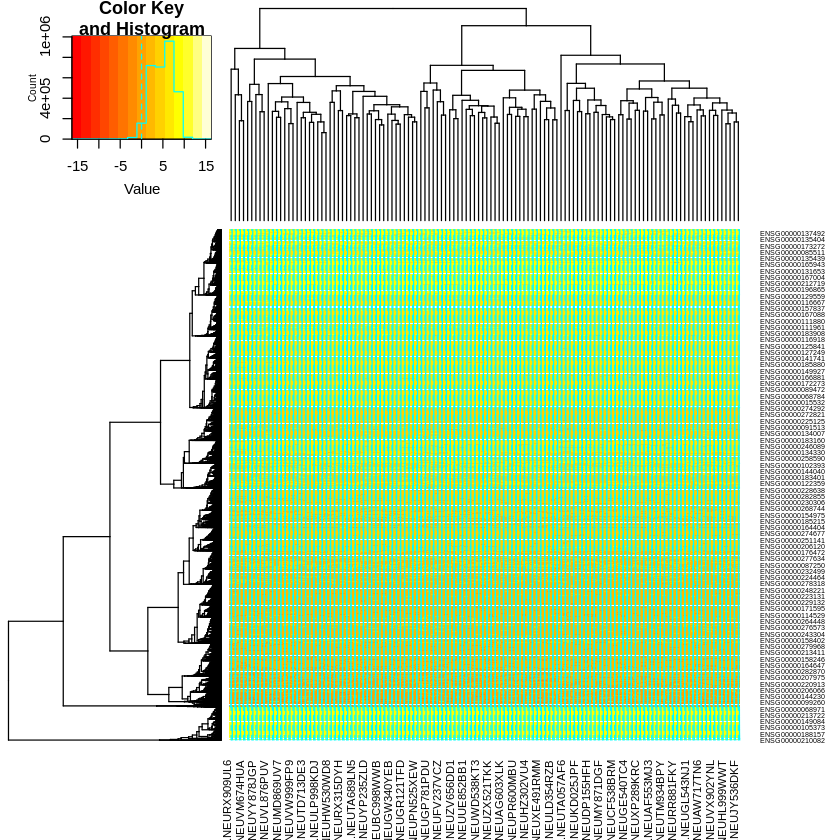

In [21]:
heatmap_corrected_data <- heatmap.2(quantile_data_removeBatchEffect, dendrogram='both', distfun = function(x) dist(x, method="euclidean"))

We extracted the individuals belonging to each cluster, Cluster1 contains 79 individuals, while Cluster2 has 45. To characterize the clusters and assess their clinical relevance and see if the differences were associated with the prognosis of ALS, we performed statistical tests comparing both clusters.  

In [22]:
hc <- as.hclust( heatmap_corrected_data$colDendrogram )
clusters <- cutree(hc, k=2 )
# clusters_corrected_data <
transcripts_groups$clusters <- clusters


In [25]:
#statistical comparation
lapply(transcripts_groups[,6:10], function(x) kruskal.test(x ~ clusters, data=transcripts_groups))

$NEFH

	Kruskal-Wallis rank sum test

data:  x by clusters
Kruskal-Wallis chi-squared = 2.3127, df = 1, p-value = 0.1283


$ISL1

	Kruskal-Wallis rank sum test

data:  x by clusters
Kruskal-Wallis chi-squared = 0.25696, df = 1, p-value = 0.6122


$NKX6

	Kruskal-Wallis rank sum test

data:  x by clusters
Kruskal-Wallis chi-squared = 1.3666, df = 1, p-value = 0.2424


$TUBB3

	Kruskal-Wallis rank sum test

data:  x by clusters
Kruskal-Wallis chi-squared = 0.86689, df = 1, p-value = 0.3518


$s100b

	Kruskal-Wallis rank sum test

data:  x by clusters
Kruskal-Wallis chi-squared = 13.793, df = 1, p-value = 0.0002041



In [27]:
lapply(transcripts_groups[,11:16], function(x) kruskal.test(x ~ clusters, data=transcripts_groups))

$ALSFRSBaseline

	Kruskal-Wallis rank sum test

data:  x by clusters
Kruskal-Wallis chi-squared = 0.14865, df = 1, p-value = 0.6998


$ALSFRSLatest

	Kruskal-Wallis rank sum test

data:  x by clusters
Kruskal-Wallis chi-squared = 0.38907, df = 1, p-value = 0.5328


$ALSFRSProgressionSlope

	Kruskal-Wallis rank sum test

data:  x by clusters
Kruskal-Wallis chi-squared = 5.0287, df = 1, p-value = 0.02493


$CBSBaseline

	Kruskal-Wallis rank sum test

data:  x by clusters
Kruskal-Wallis chi-squared = 0.032613, df = 1, p-value = 0.8567


$CBSLatest

	Kruskal-Wallis rank sum test

data:  x by clusters
Kruskal-Wallis chi-squared = 1.9823, df = 1, p-value = 0.1591


$CBS.Progression.Slope

	Kruskal-Wallis rank sum test

data:  x by clusters
Kruskal-Wallis chi-squared = 1.2257, df = 1, p-value = 0.2682



In [ ]:
# Diferential expression analisis
# Declare covariantes
NKX <- transcripts_groups$NEFH
NEFH <- transcripts_groups$ISL1
TUBB3 <- transcripts_groups$NKX6
ISL1 <- transcripts_groups$TUBB3
s100b <- transcripts_groups$s100b
sex <- transcripts_groups$Sex
race <- transcripts_groups$Race
clusters <- factor(transcripts_groups$clusters)

In [ ]:
design_matrix <- model.matrix(~0 + clusters + NKX + NEFH + TUBB3 + ISL1 + s100b + race + sex )

colnames(design_matrix) <- c('clusters_one1', 'clusters_one2','NKX', 'NEFH', 'TUBB3', 'ISL1', 's100b',
                     'race1', 'race2',
                        'race3', 'rece4', 'sex') 


# fit data
fit_case_clusters <- lmFit(as.matrix(log_quantile_norm_data), design_matrix)
# contrast case vs control data
cont.matrix_cluster <- makeContrasts(clusters_one1-clusters_one2, levels = design_matrix)
fit_case_clusters <- contrasts.fit(fit_case_clusters, cont.matrix_cluster)
fit_case_clusters <- eBayes(fit_case_clusters)

#cluster1 vs all
DEP_SIG_ALS_cluster1_vs_cluster2 <- topTable(fit_case_clusters, adjust = "BH", coef = 1,
                                           number = length(fit_case_clusters$coefficients)) 
# Filter by  p.adjust.val
DEP_SIG_ALS_cluster1_vs_cluster2 <- DEP_SIG_ALS_cluster1_vs_cluster2[ DEP_SIG_ALS_cluster1_vs_cluster2$adj.P.Val < 0.05, ]
DEP_SIG_ALS_cluster1_vs_cluster2
write.csv(DEP_SIG_ALS_cluster1_vs_all, 'cluster1_vs_cluster2_corrected.csv') # Cluster

Discussion

We observed a significant difference in the ALSFRS progression slope between the identified gene expression clusters.

 We did not find any differences in the ALSFRS value at baseline or latest time point. This lack of differences may be due to problems with clinical source documentation and patient followup data. Some individuals only have one clinic visit and the clinical values for the baseline observation and latest time point appear as the same in the data portal table. The number of  clinic visits at which the latest point was collected is variable and it is ad hoc and retrospective, resulting in too much variability. Without having robust, complete clinical data  from all patients and the information of how this data was calculated it is difficult to draw accurate conclusions, thus we suggest to develop a well designed clinical protocol for key reference centers and include this information in the future.
 
For all the differential expression analysis performed during this project we have corrected for the cell differentiation stages by including the staining markers as covariates. 

There were  significant differences in S100B, an astrocyte marker. High levels of extracellular S100B may induce autocrine astrocytic activation that turns astrocytes into a proinflammatory and neurodegenerative phenotype (Villarreal et al. J Neurochem. 2014 Oct;131(2):190-205.) It has also been suggested that S100B expression might be an early occurring event in the ALS (Serrano et al. Mediators Inflamm. 2017; 2017: 1626204), so it might also be playing a role in the progression of the disease. We observed a higher percentage of cells with SB100 staining in Cluster1, suggesting they have more neurodegeneration than Cluster2. Moreover, SB100 protein positively correlates with a worse prognosis of ALS. (Sussmuth et al. Neurology. 2010;74(12):982–987)
 
Interestingly, after the differential expression analysis, we found that L13a-mediated translational silencing of Ceruloplasmin expression is regulated differently in Cluster1 compared to Cluster2, suggesting a higher expression of ceruloplasmin in Cluster one compared to cluster2. Ceruloplasmin is known to be altered in neurological diseases, as ceruloplasmin is related to iron/copper metabolism, it is linked to neurologic symptoms and signs. This result supports the idea that Cluster1 has more neurodegeneration and disease progression.
 
Selenocysteine synthesis is another pathway relevant to ALS, as it has been shown that the cerebrospinal fluid of ALS patients contains elevated levels of selenium species. A recent study suggests that these elevated levels result from mutations causing ALS, as they only observed this in a patient with a mutation in TUBA4A (Mandrioli Et al. Neurodegener Dis 2017;17:171-180). A further study comparing the genetic mutation from patients in Cluster1 with Cluster2 could help us to assess if there is indeed a genetic component involved in this pathway. 
 
Other pathways potentially related to ALS include Response of EIF2AK4 (GCN2) to amino acid deficiency showing different regulation in Cluster1 compared to Cluster 2 are response of EIF2AK4 (GCN2) to amino acid deficiency, eukaryotic translation elongation and  endosomal/vacuolar pathway.
 
One of the major limitations of our study is the number of missing values in the clinical data. We correlated the clusters to the data available in the data portal metadata, but when we tried the same with the parameters from other tables, we had many missing values. We consider that a more complete dataset would allow us to better assess the clinical relevance of these clusters.

In conclusion, we identified two subgroups of ALS patients that have different transcriptomic profiles. Main difference between the groups seems to be the neurodegeneration levels, as most of the pathways identified are related to it. Additionally, we observed differences in parameters associated with disease progression as the ALSFRS progression slope and the percentage of cells stained with SB100 were correlated. The pathway analysis at Reactome  identified the mechanisms in which these genes were involved stratifying by down- and up-regulated genes. The down-regulated genes are overrepresented significantly in multiple pathways (FILE). The gene expression results and the identification of Cluster1 and Cluster2 will allow the generation of hypotheses that will be tested in the current dataset.
 

